In [37]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import paste
import scanpy as sc
import anndata
from sklearn.decomposition import NMF
import scanorama
import scipy

style.use('seaborn-dark')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

In [38]:
def rotate_spots(grid,spots,theta=0,translation=0,center_correction=0,figsize=(5,5),plot=True):
    grid = grid.copy() + center_correction
    spots = spots.copy() + center_correction
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    rotated_spots = np.array([R.dot(spots[i]) for i in range(len(spots))])
    rotated_spots += translation

    new_spots = grid[np.argmin(scipy.spatial.distance.cdist(rotated_spots,grid),axis=1)]

    grid -= center_correction
    spots -= center_correction
    rotated_spots -= center_correction
    new_spots -= center_correction

    seen = {}
    mapping = []
    for i in range(len(new_spots)):
        if tuple(new_spots[i]) in seen: continue
        seen[tuple(new_spots[i])] = 1
        mapping.append(i)

    if plot:
        fig = plt.figure(figsize=figsize)
        sns.scatterplot(x = grid[:,0],y = grid[:,1],linewidth=0,s=100, marker=".",alpha=0.2,color='blue')
        sns.scatterplot(x = rotated_spots[:,0],y = rotated_spots[:,1],linewidth=0,s=100, marker=".",color='red')
        sns.scatterplot(x = new_spots[:,0],y = new_spots[:,1],linewidth=0,s=100, marker=".",color='green')
        plt.show()

    return new_spots,mapping

## Read in Data

In [39]:
def load_breast_layer(path):
    X = pd.read_csv(path, delimiter = '\t', index_col= 0)
    coor = []
    for c in X.index:
        coor.append([float(x) for x in c.split('x')])
    adata = anndata.AnnData(X = X)
    adata.obsm['spatial'] = np.array(coor)
    return adata

In [40]:
layer1_path = "../breast_cancer_data/Layer1_BC_count_matrix-1.tsv"
layer2_path = "../breast_cancer_data/Layer2_BC_count_matrix-1.tsv"
layer3_path = "../breast_cancer_data/Layer3_BC_count_matrix-1.tsv"
layer4_path = "../breast_cancer_data/Layer4_BC_count_matrix-1.tsv"

In [41]:
adata_layer_1 = load_breast_layer(layer1_path)
adata_layer_2 = load_breast_layer(layer2_path)
adata_layer_3 = load_breast_layer(layer3_path)
adata_layer_4 = load_breast_layer(layer4_path)

## Define Simulation functions

### Simulate Spatial Noise

Takes a layer, rotates by angle. Next, we map all coordinates to closest integer coordinates.

This removes some points as two points who share the same closest integer pair will map to same coordinate.

In [42]:
def simulate_spatial(adata, rotation_angle):
    adata_sim = adata.copy()
    grid_size = 40
    layer_grid = np.array([[x,y] for x in range(grid_size) for y in range(grid_size)])
    new_spots, mappings = rotate_spots(layer_grid, adata.obsm['spatial'], center_correction=-15, theta= rotation_angle)
    adata_sim.obsm['spatial'] = new_spots
    return adata_sim[mappings, :], mappings

### Simulate Gene Expression

In [43]:
def simulate_gene_exp(adata, pc = 0.25, factor = 1):
    """
    Adds noise to gene expression data. The rows are simulated according to a Multinomial distribution, 
    with the total counts per spot drawn from a Negative Binomial Distribution.
    param: pc- Pseudocount to be added to dataframe
    param: factor - amount by which we scale the variance (to increase noise)
    """
    adata_sim = adata.copy()
    df = pd.DataFrame(adata_sim.X)
    # add pseudocounts 
    alpha = df.copy().to_numpy() + pc

    # get vector of total counts per spot
    n = df.sum(axis=1).to_numpy()

    # Simulate total counts using negative binomial
    mean = np.mean(n)
    var = np.var(n)*factor
    n = sample_nb(mean, var, len(n)).astype(int)

    # Reassign zero counts so we don't divide by 0 in future calcuation
    n[n == 0] = 1

    # convert to float
    alpha = np.array(alpha, dtype=np.float64)
    n = np.array(n, dtype=np.float64)

    # convert rows to unit vectors
    alpha = alpha/alpha.sum(axis=1)[:, None]

    dist = np.empty(df.shape)
    for i in range(alpha.shape[0]):
        dist[i] = np.random.multinomial(n[i], alpha[i])
    new_df = pd.DataFrame(dist, index= df.index, columns= df.columns)
    adata_sim.X = new_df
    return adata_sim

def sample_nb(m, v, n = 1):
    """
    param: m - mean
    param: v - variance
    param: n - number of samples
    return: random sample from negative binomial distribution
    """
    r = m**2/(v - m)
    p = m/v
    samples = np.random.negative_binomial(r, p, n)
    return samples

## Define Center Simulation

In [45]:
def sim(base_layer, p, alpha):
    base_layer = base_layer.copy()
    # the following block of code is if you want your initial layer to be low dimensional
    # model = NMF(n_components=15, solver = 'mu', init='random', beta_loss = 'kullback-leibler')
    # W = model.fit_transform(base_layer.X)
    # H = model.components_
    # base_layer.X = pd.DataFrame(np.dot(W, H))
    sim_layers = []
    maps = []
    theta_angles = [math.pi/6, math.pi*2/6, math.pi*4/6]
    for i in range(3):
        adata_layer_sim_spatial, mappings = simulate_spatial(base_layer, theta_angles[i])
        adata_layer_sim_both = simulate_gene_exp(adata_layer_sim_spatial, pc = p)
        sim_layers.append(adata_layer_sim_both)
        maps.append(mappings)
    
    lmbda = len(sim_layers)*[1/len(sim_layers)]
    base_layer = simulate_gene_exp(base_layer, pc = p)
    center_slice, pis = paste.center_align(base_layer, sim_layers, lmbda, alpha = alpha, n_components= 15)
    
    result = []
    for m, p in zip(maps, pis):
        s = 0
        for i in range(len(m)):
            s += p[m[i]][i]
        result.append(s)
    return result


## Run simulations

IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII= 0


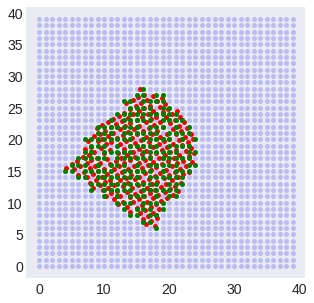

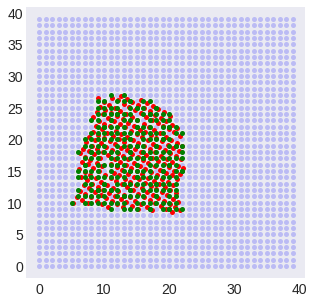

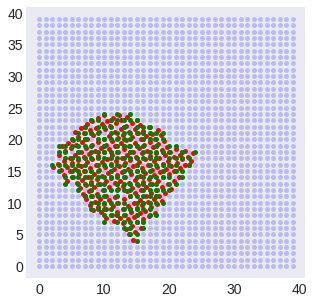

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 1.9496648741425355

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.05112163549115234

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mappi

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.004653031648427675

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.004432509438332399

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.010960432472350234

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.007

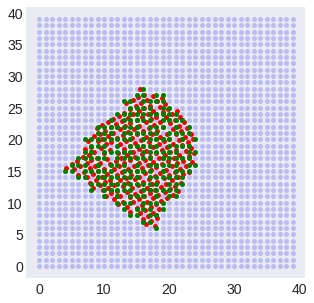

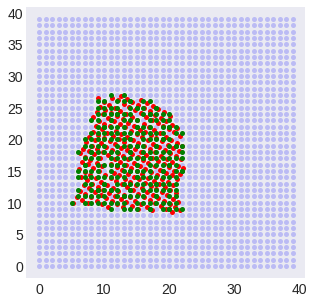

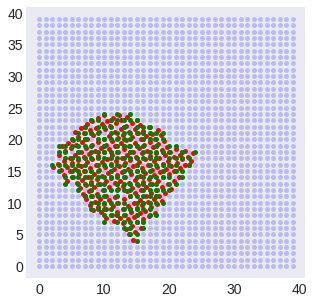

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 2.0731422266280175

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.06655623821793055

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.021610686485509678

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0053859159616811425

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.001

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0013736948606684063

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.010514197993565011

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0030264709756109287



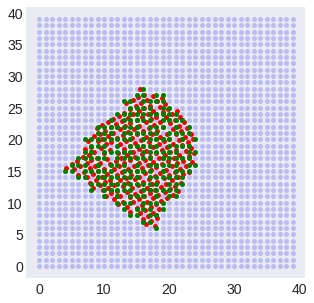

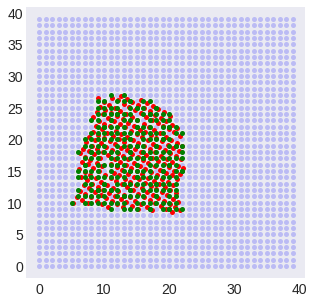

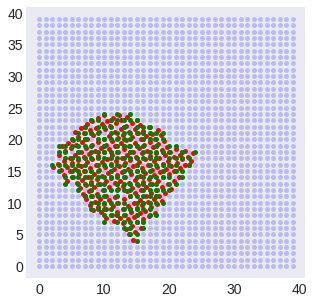

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0



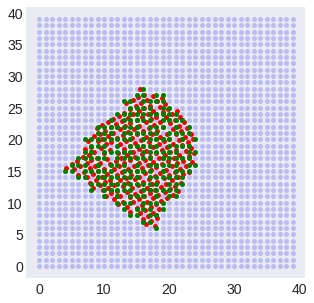

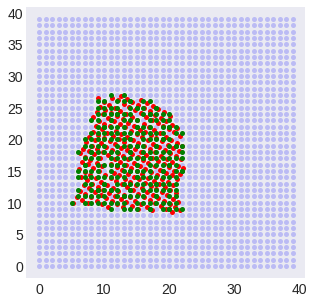

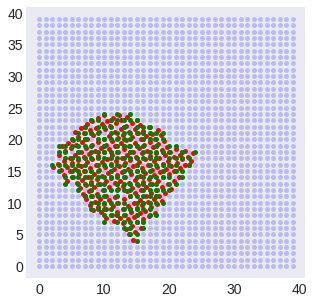

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8078226560777426

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.13594182284991474

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0011759180146586612

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0009760809728560638



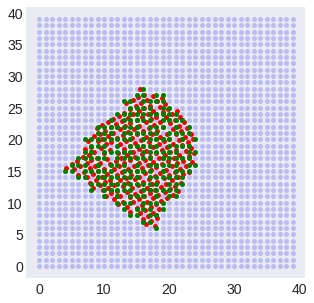

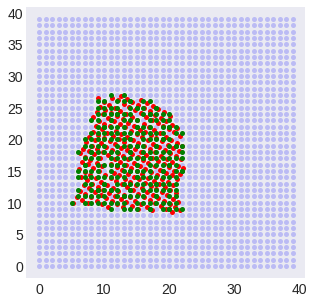

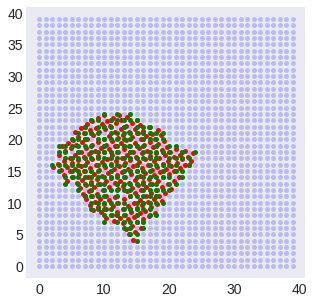

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9943352322838068

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1589382680902578

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0027823912576629972

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0019836514393731797

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0012083379214828938

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0017940670036675765

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00029533975460793727



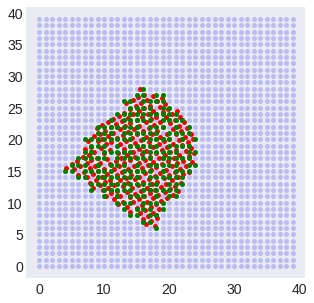

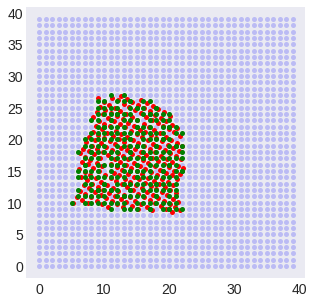

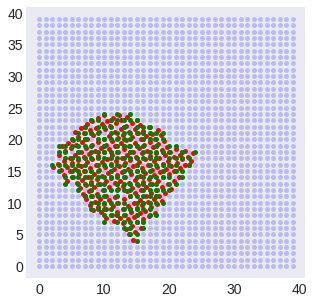

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



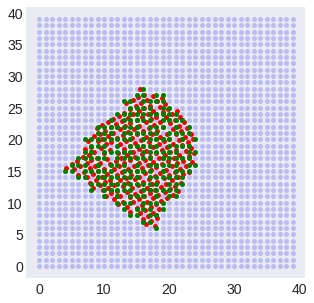

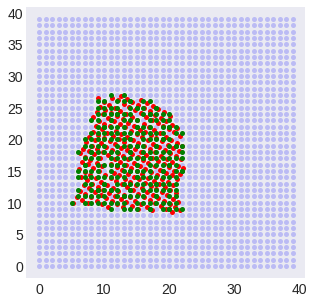

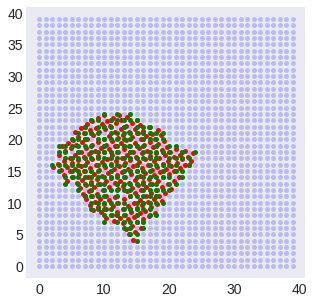

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8551019480336886

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1500684151706

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0007059075003885695



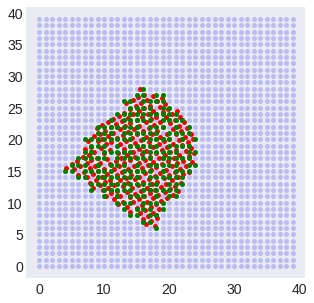

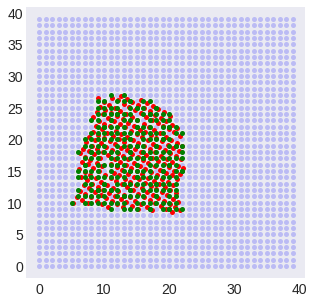

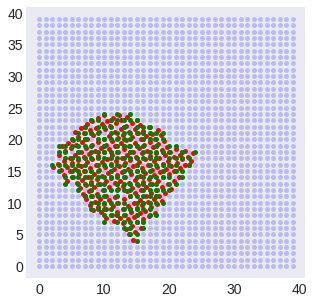

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.000890649051078

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1612927240164601

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0025492548598222697

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00039347215127794044



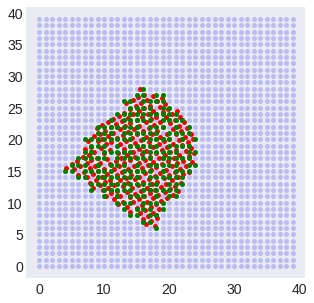

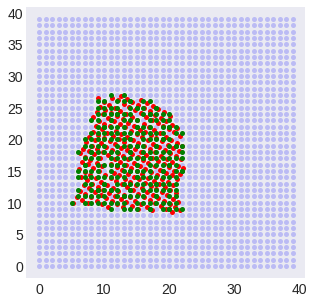

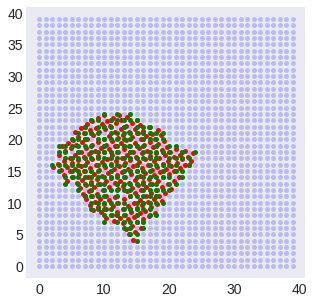

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



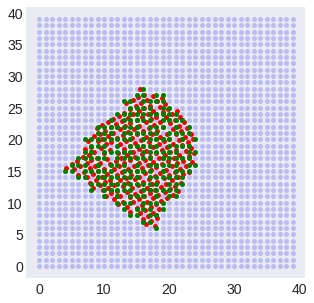

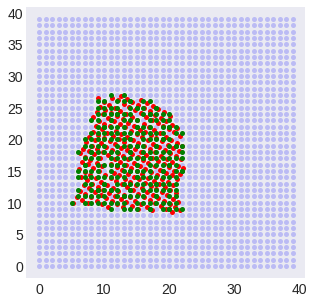

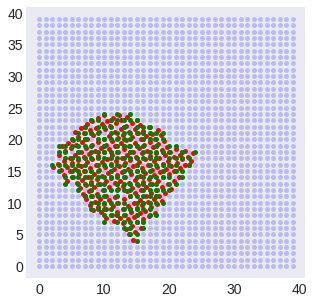

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.834332511633383

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1505299974665255

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0011716071741458833

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0009414858739678067



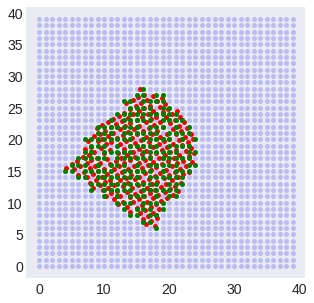

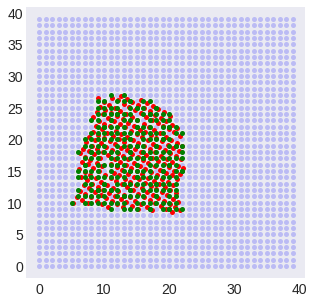

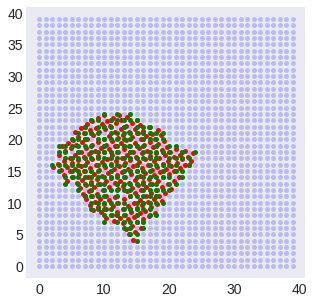

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.022535678661761

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.16599311452726373

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0018105275925786035

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00029800113037281584



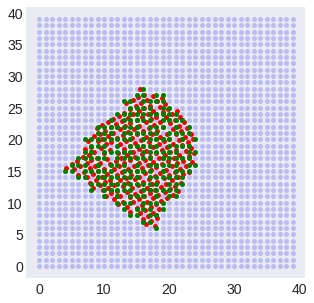

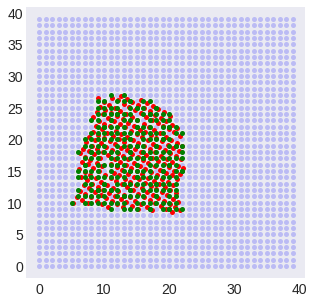

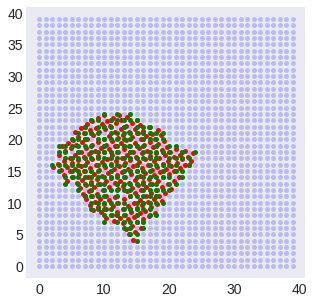

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



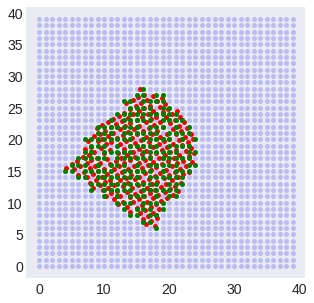

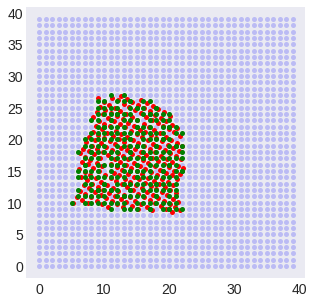

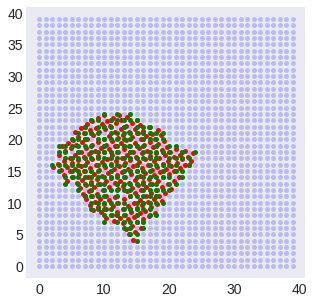

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8292388459093458

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.14511699286237123

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0012065050116205622

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0014189331585765519

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0006002484610521108



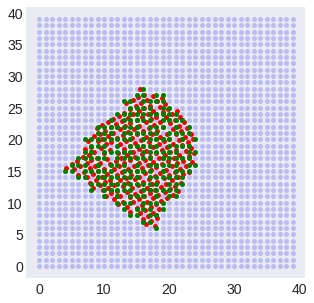

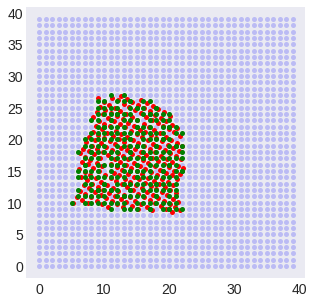

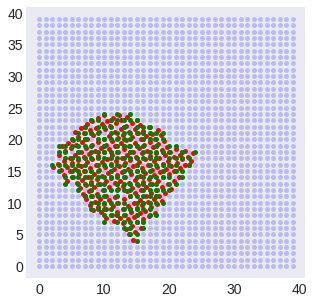

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.0174682284214063

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.16272014491631692

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0006590413956286678



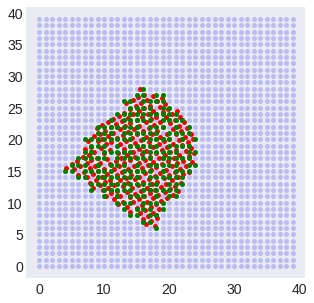

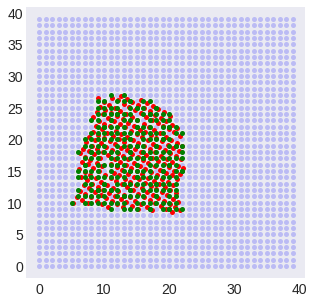

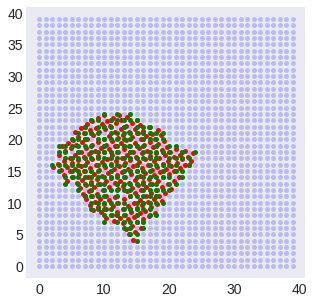

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



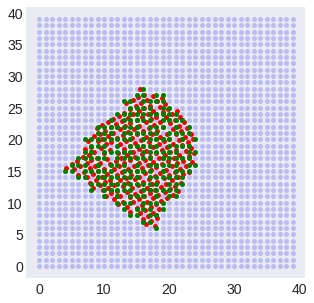

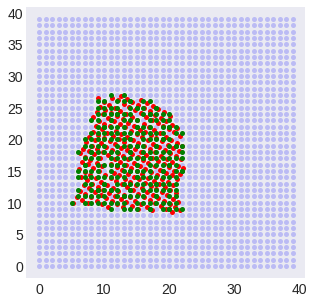

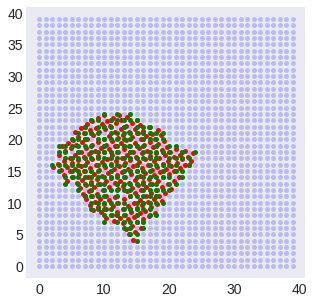

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.905418939829607

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15708205881992487

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0008409918621470336



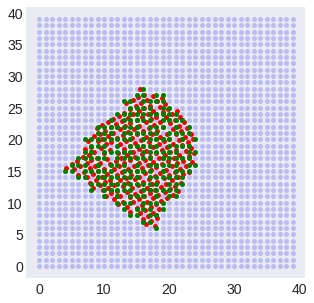

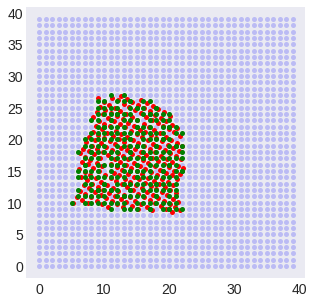

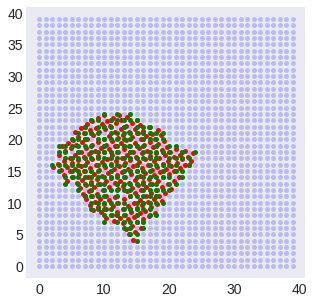

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.0233824537217506

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15216887889070962

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0011558283233270572

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.001365718996266585

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 5.9448514655668916e-05



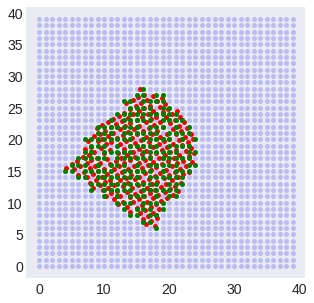

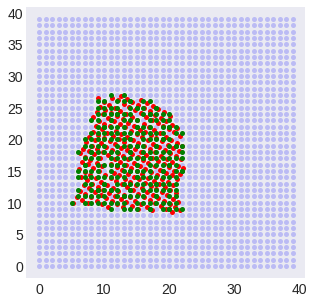

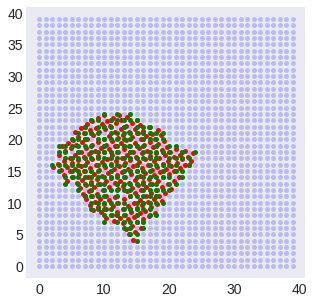

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0

IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII= 1


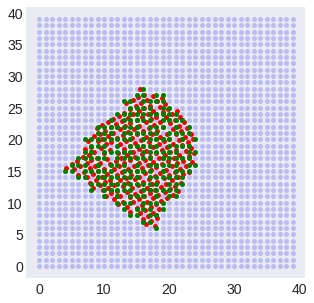

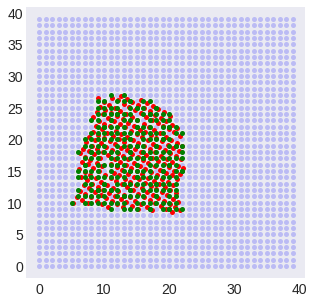

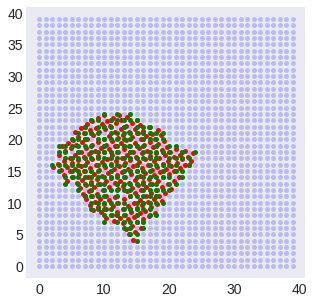

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 1.955651719099845

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.047302388513982496

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mappi

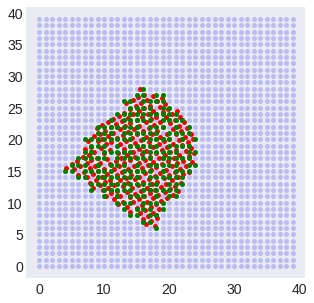

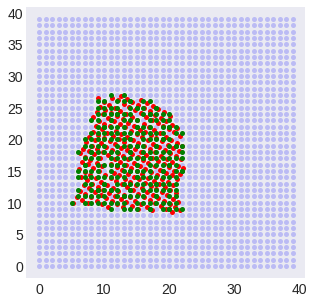

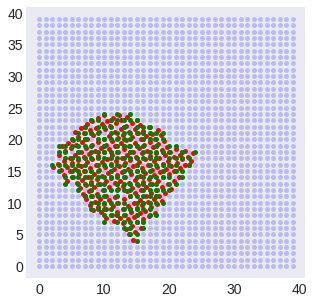

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 2.0460998241518604

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0624039939307357

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mappin

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.004279050434796261

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0040715647549653955



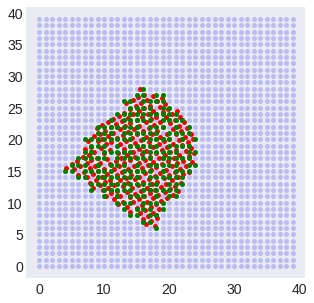

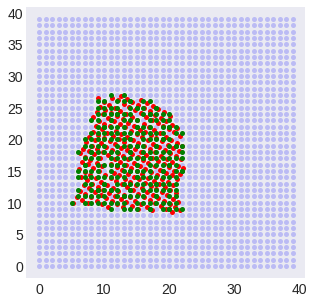

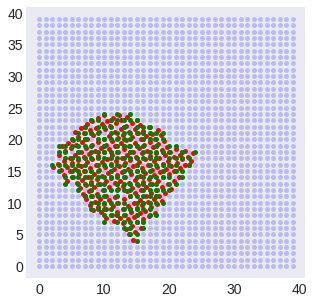

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0



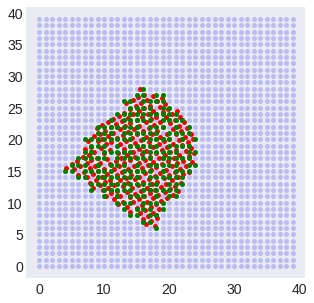

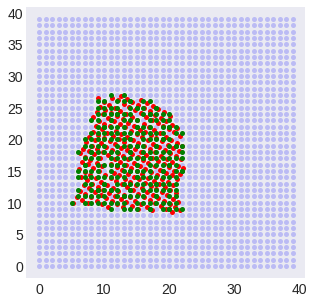

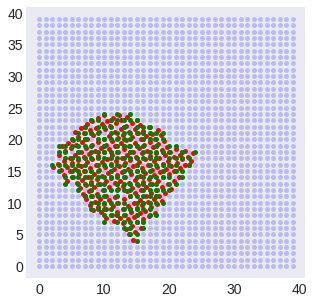

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.81184774815036

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.14965088423801398

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.000951935529951653



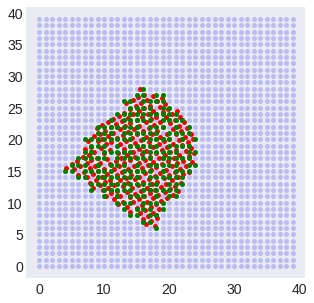

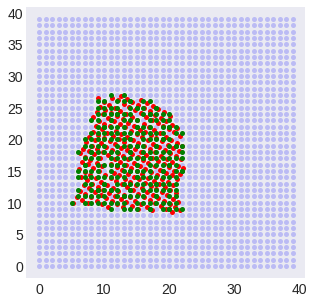

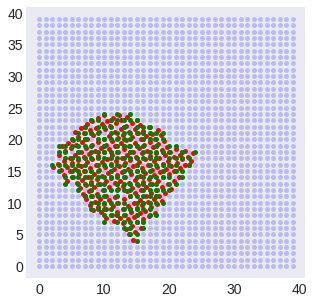

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9757041119018126

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15044263948134295

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.003391951520187675

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 9.979601974707819e-05



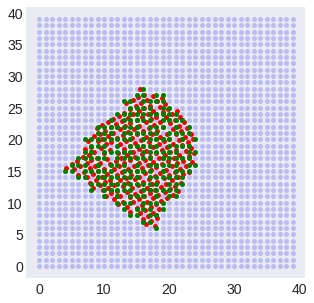

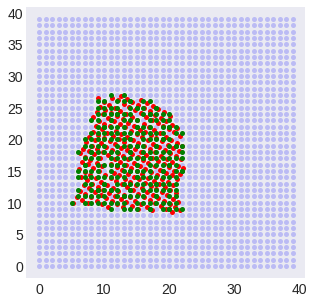

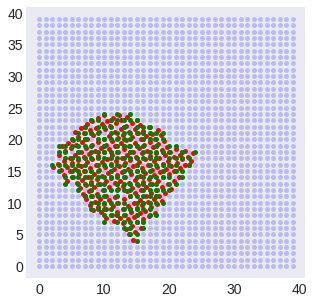

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



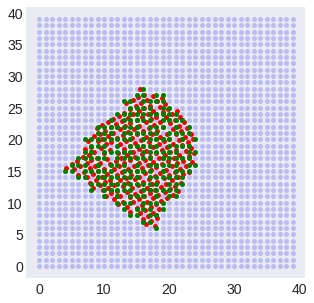

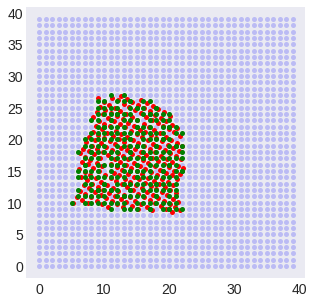

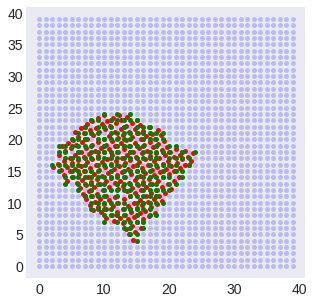

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9105408775466568

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15135592227418826

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.000568597893705336



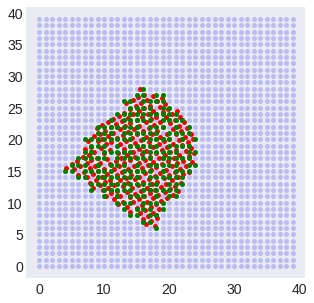

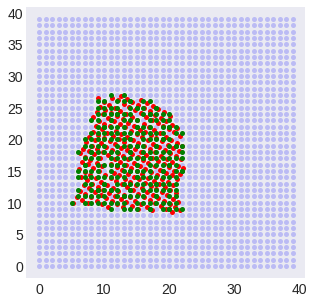

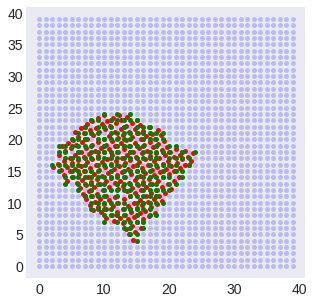

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9767082090548231

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.16179651075873136

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0015839428743535944

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.002234229540982957

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0027379303245933517

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0011865069358198976

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0009091841905288778



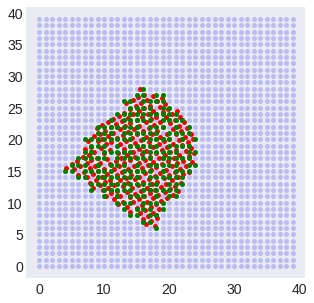

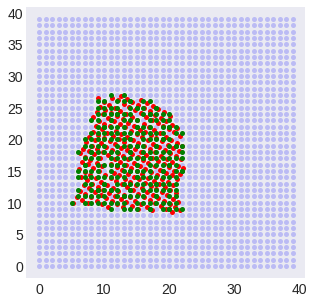

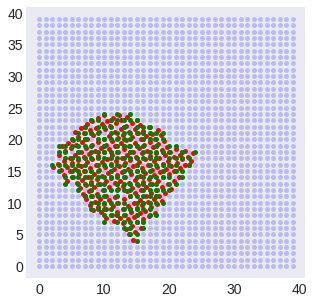

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



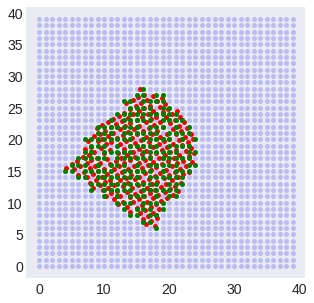

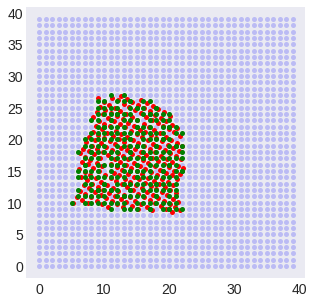

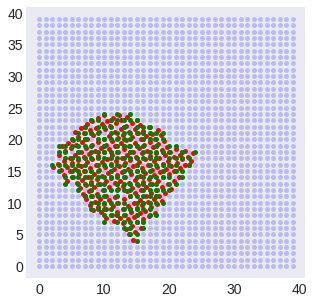

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8641248329844915

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15060964156369638

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00015893903425756584



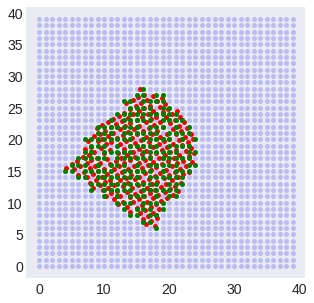

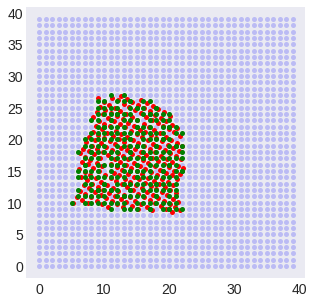

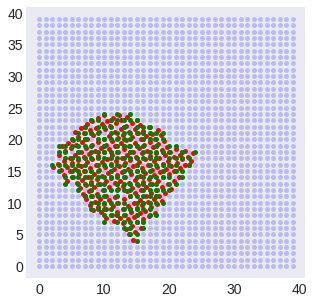

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.0008437108103023

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15697003316389235

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0004637235530089434



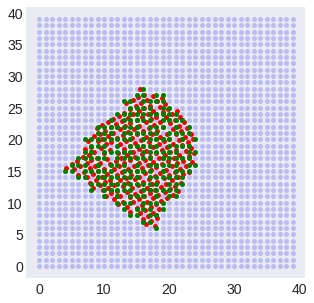

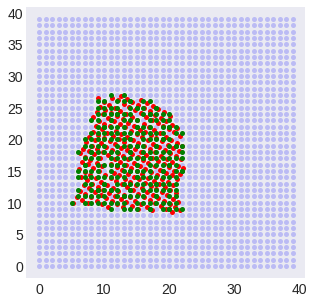

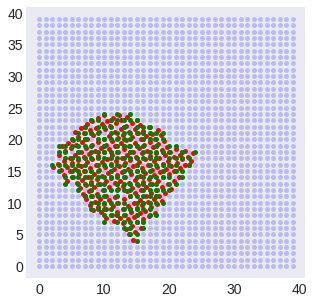

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



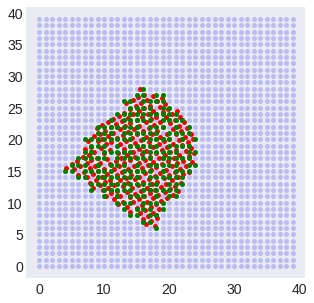

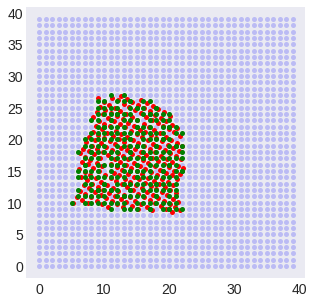

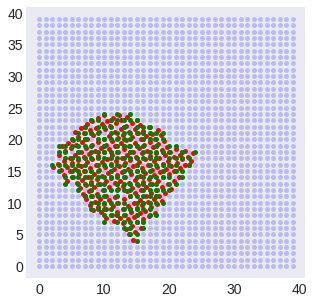

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8690228443213752

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1697878482719375

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00024865376714955367



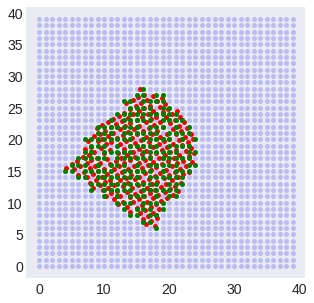

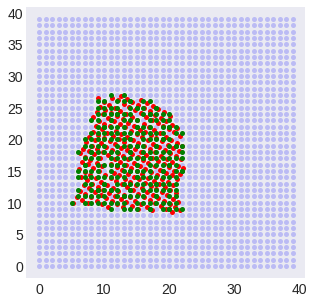

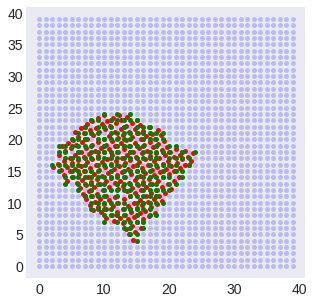

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9744507381609269

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.16398374181902065

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0009760922257022742



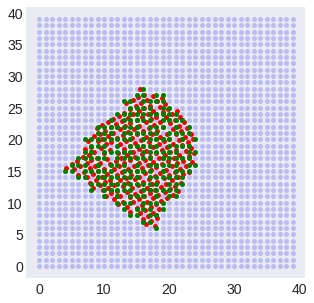

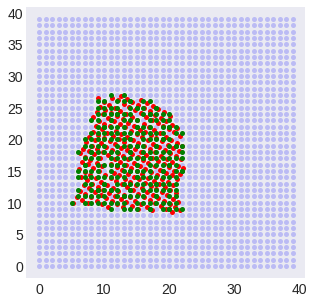

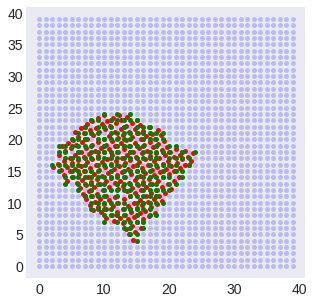

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



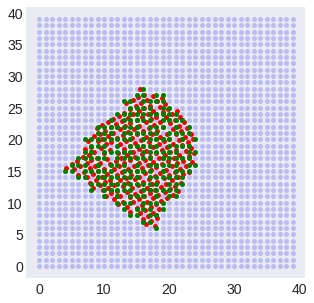

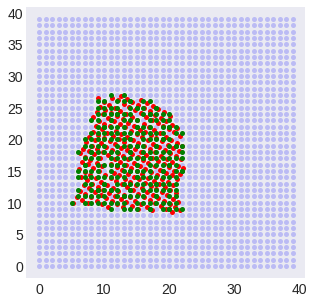

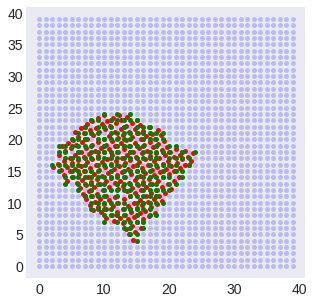

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8455136882589216

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15435396879344743

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00042933957955160196



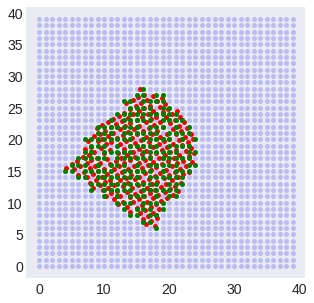

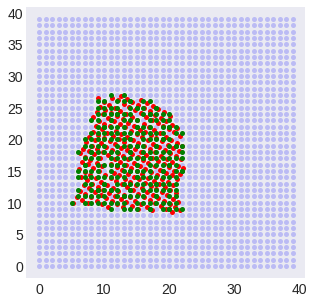

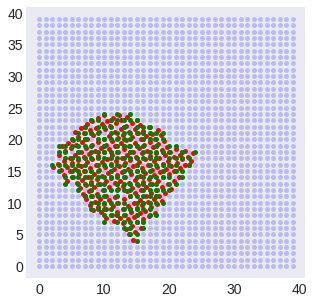

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.0286988598686815

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1674026847834642

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0007135531002790962



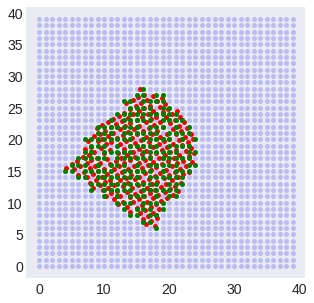

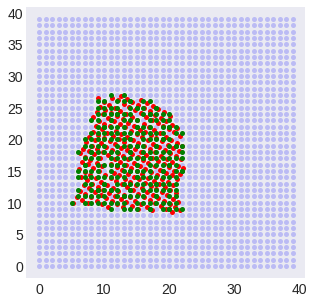

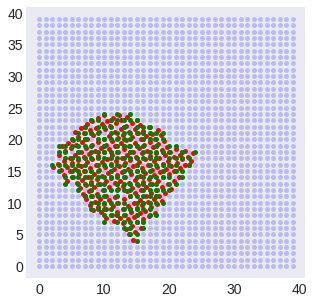

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0

IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII= 2


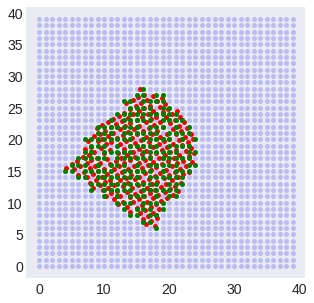

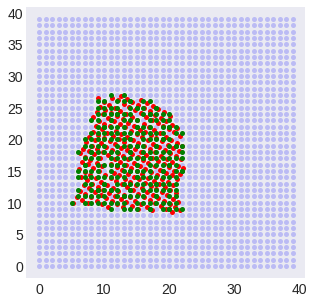

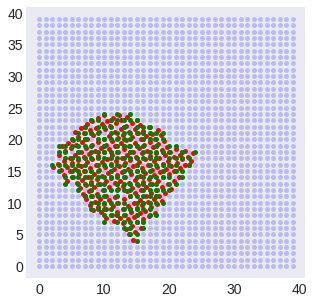

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 1.9558790285749617

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.059760144379575886

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapp

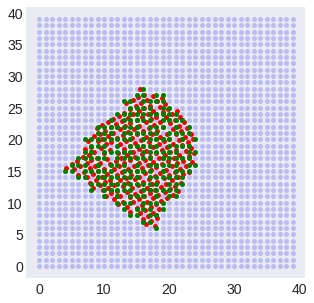

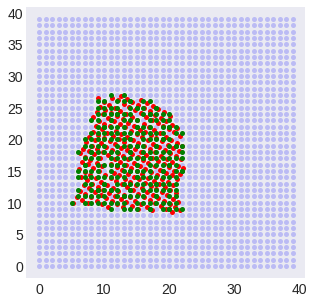

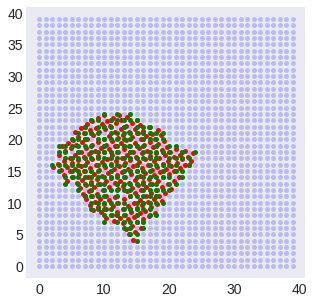

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 2.061841131192283

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.06255342038363843

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mappin

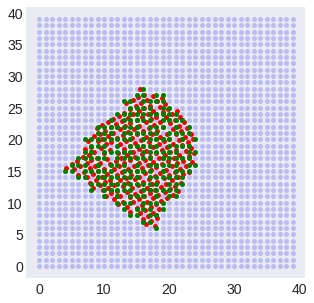

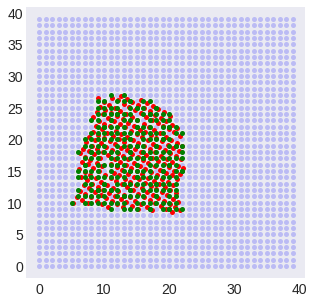

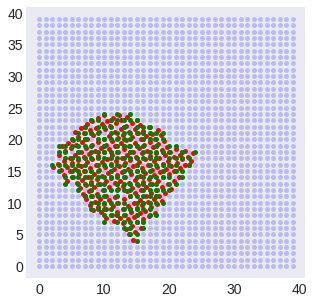

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0



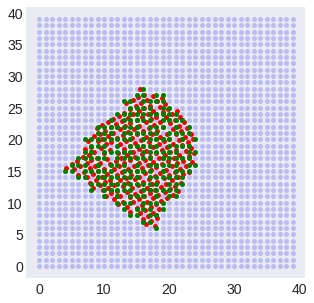

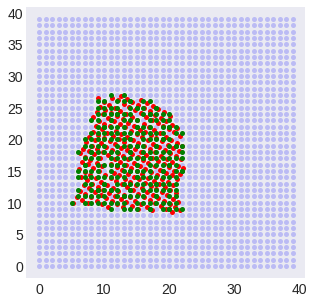

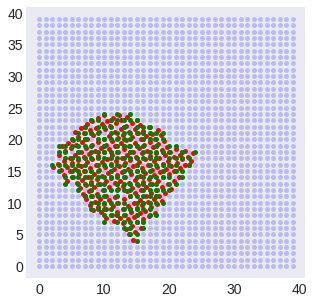

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.854082155824528

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1524216458433738

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00015434845137729525



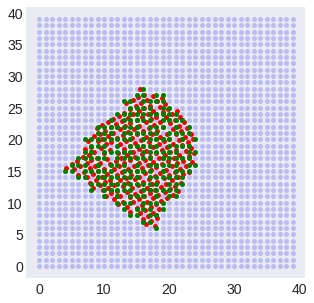

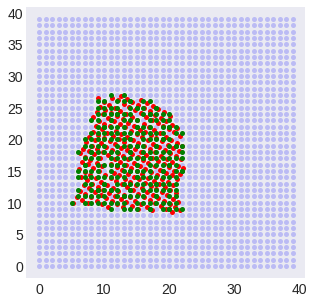

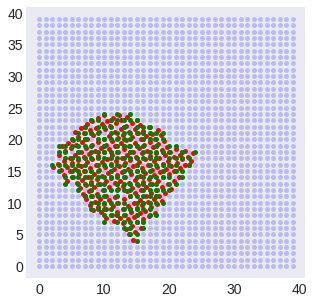

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9733281735492867

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15047386006830465

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 4.397525933552693e-05



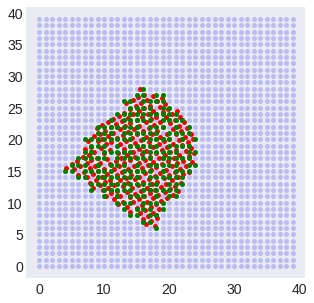

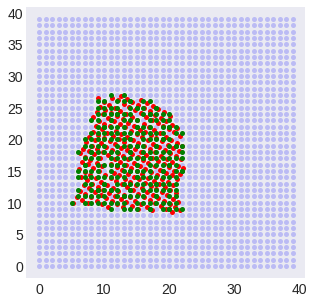

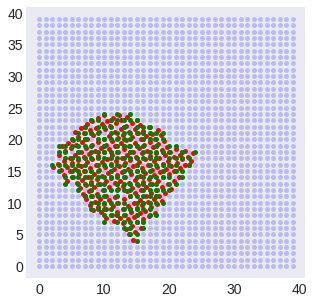

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



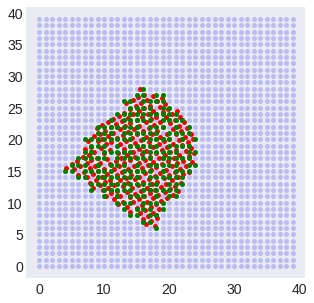

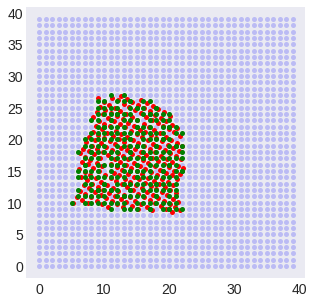

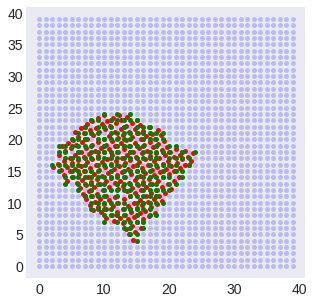

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8499342013585376

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.14595998377582697

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0015441525653345778

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0023035012251062525

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0011467273783889453

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.000517058728998876



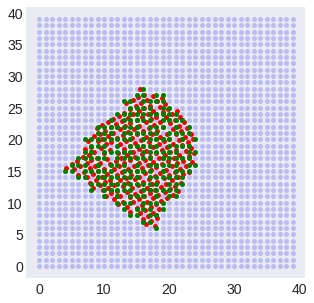

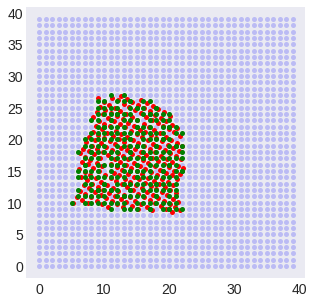

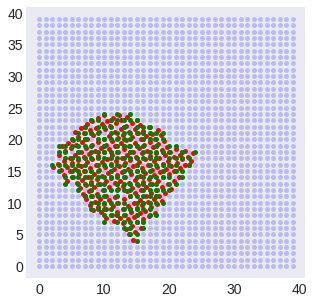

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.00771538780762

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.14902283560465546

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0016497361114609088

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0009211971501008609



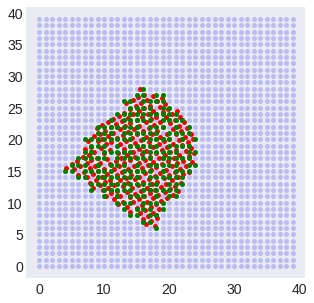

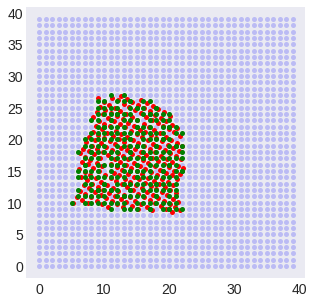

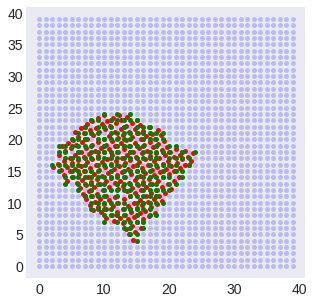

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



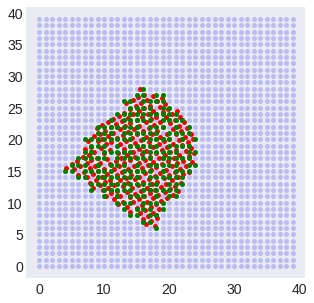

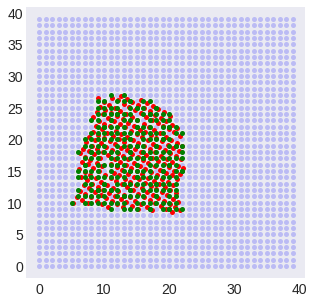

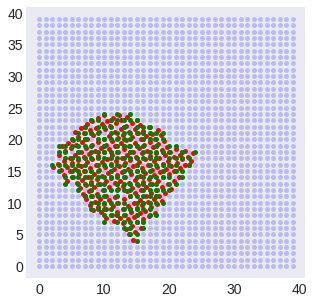

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8892792181093283

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.13929826785030186

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0016443545057587272

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00037183353322434165



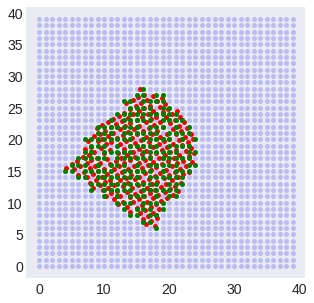

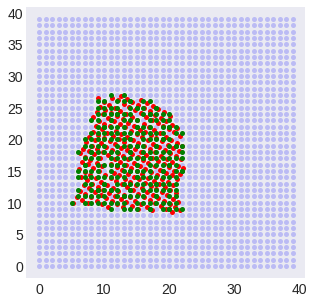

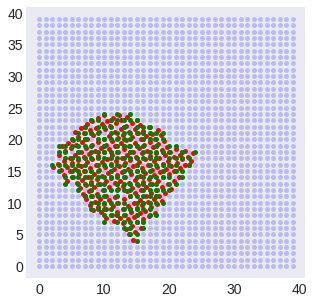

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.009703496770142

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.16440308744168397

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0017232442123262803

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0009424557685151491



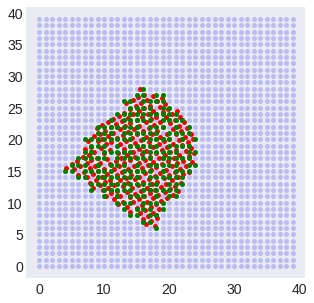

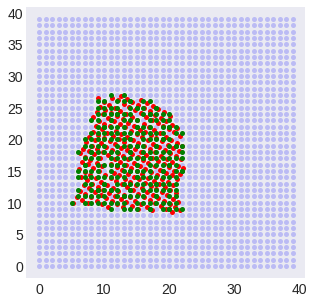

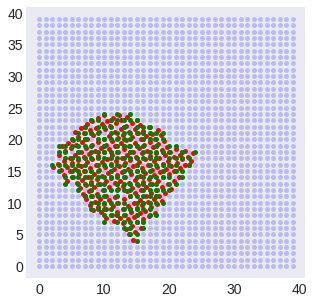

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



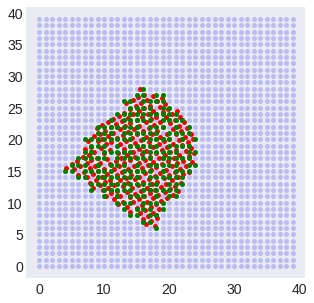

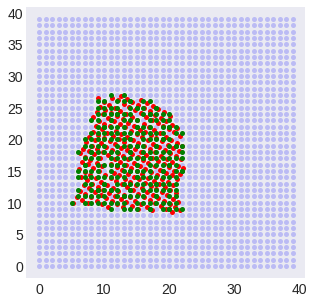

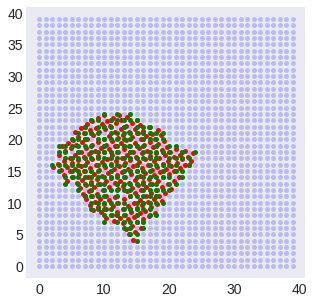

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.929983715296324

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1541725351486818

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00016641050235488564



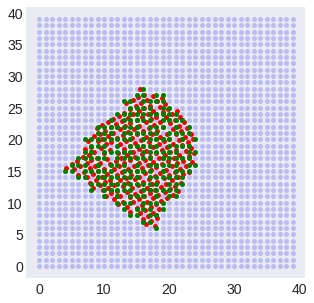

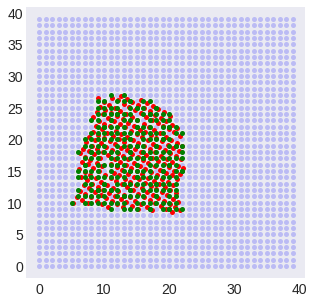

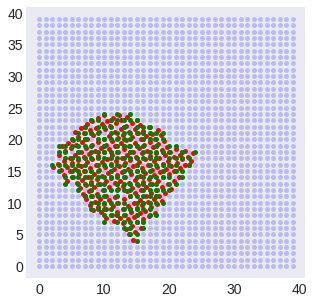

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9973361258173037

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.144861479721055

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0012577925136025847

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.004145151061673458

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0004717214713241269



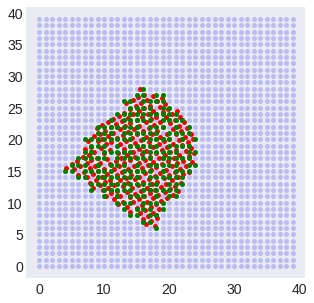

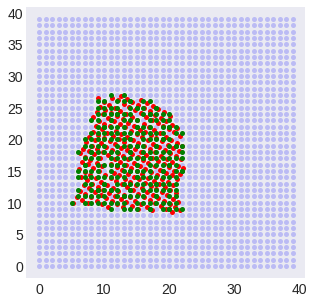

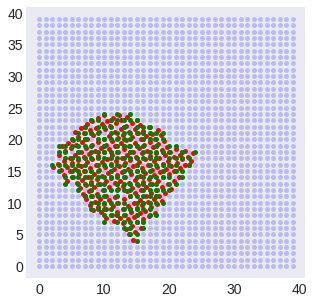

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



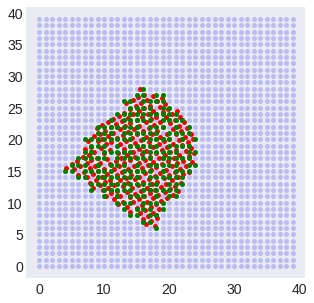

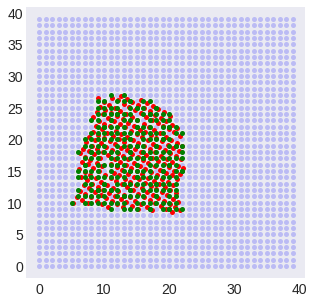

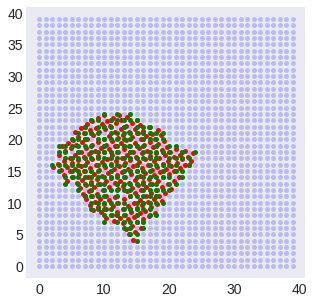

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8803258342264448

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1377873635386191

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00035903771280976216



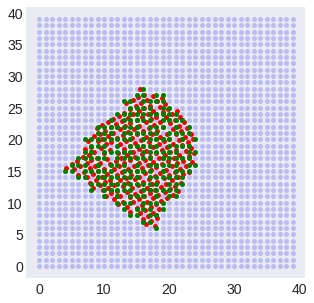

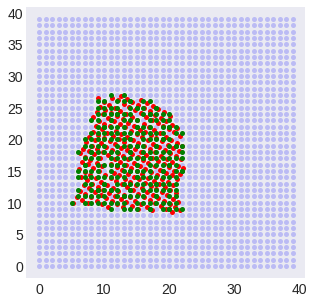

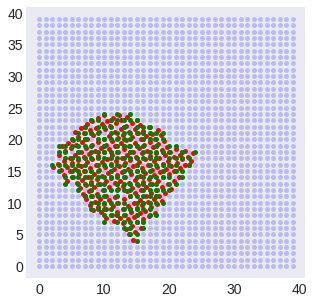

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.029775924076074

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.16208005137483728

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0017300709078109655

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0004553236119217985



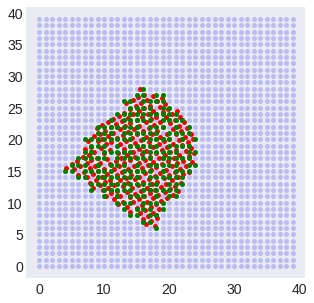

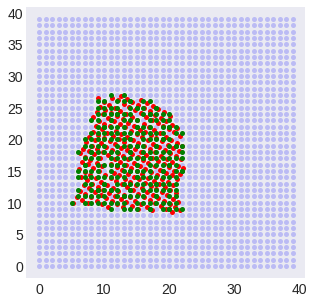

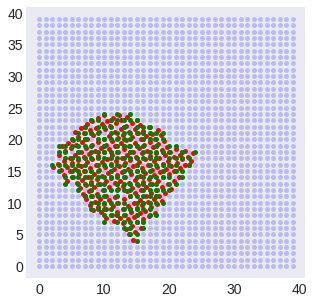

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0

IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII= 3


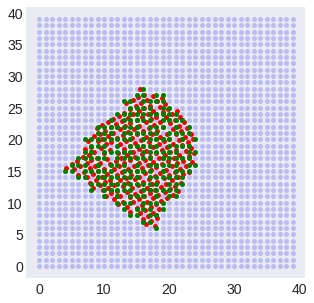

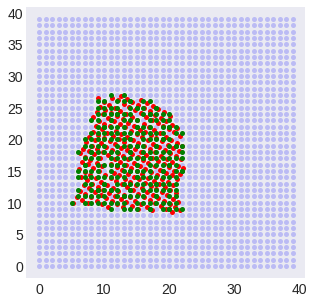

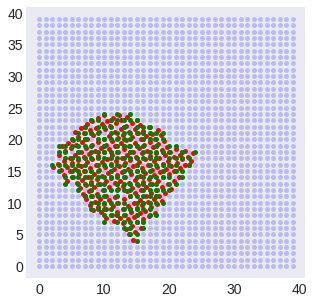

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 1.9320280495103657

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.030342915380140445

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0009602984210355103



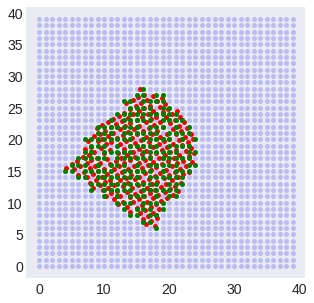

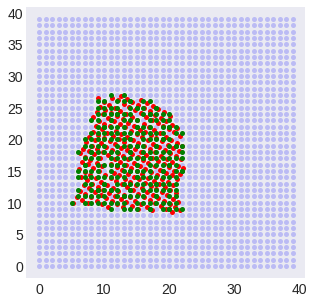

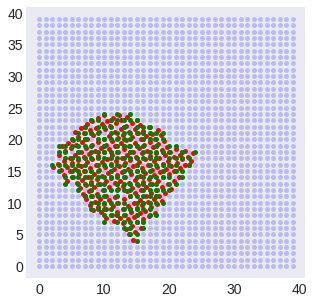

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 2.030344194878179

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.061253282724472946

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mappi

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.004224080254315643

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0034337585502737245

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.001429773563402792

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.00

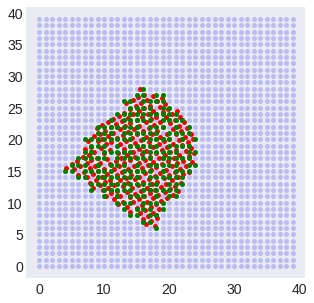

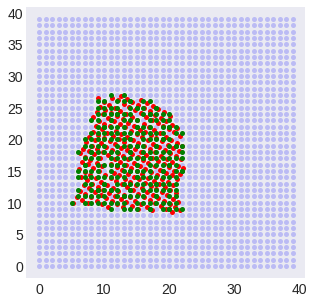

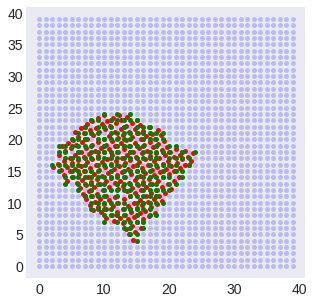

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0



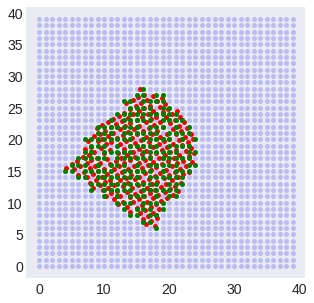

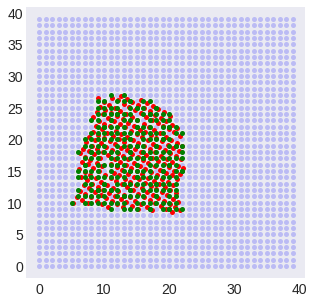

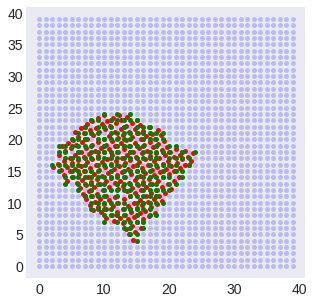

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8310347824663453

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15054804268887811

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0008516563053360127



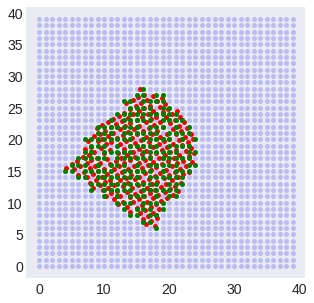

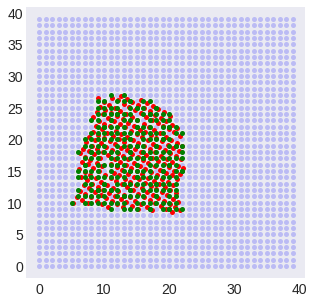

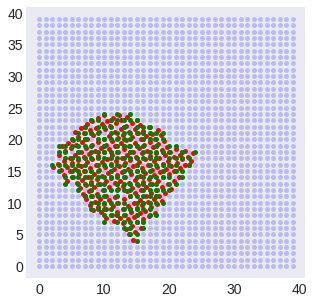

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9788201800398268

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.13963817565559156

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0008647231658114318



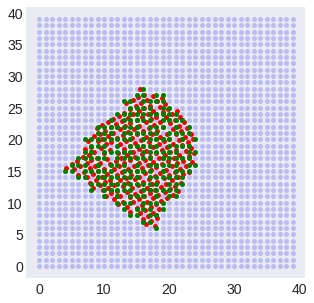

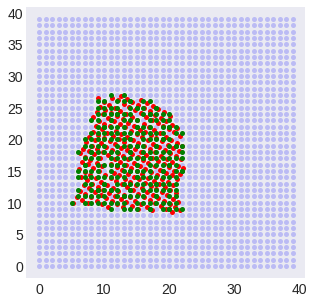

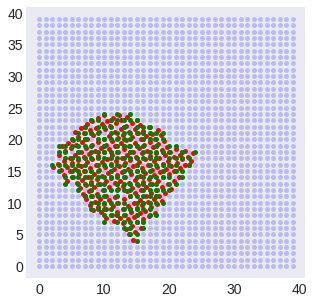

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



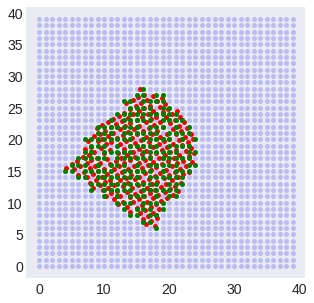

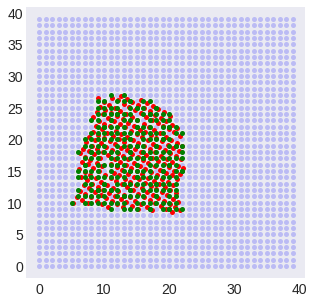

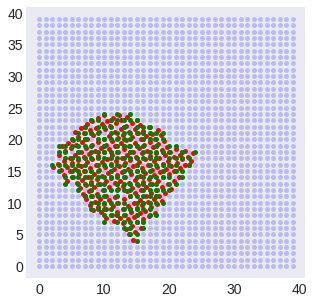

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.841011607528167

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.16133403790255652

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0005152318672165812



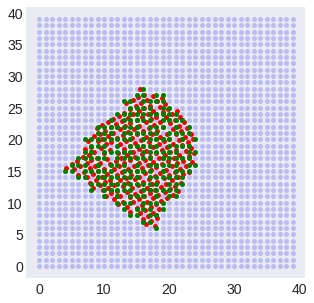

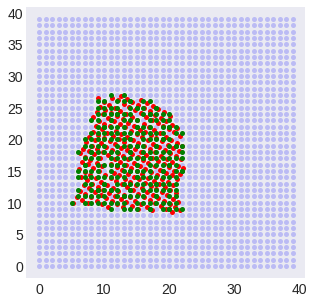

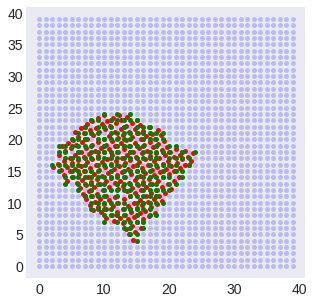

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.981080576620118

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.150768732684867

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0003580550053232656



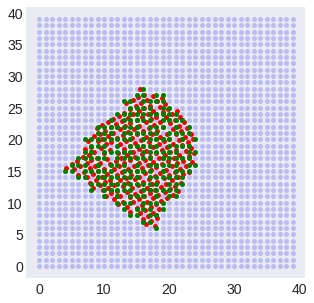

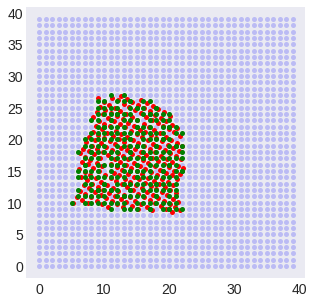

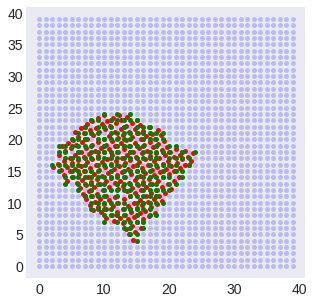

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



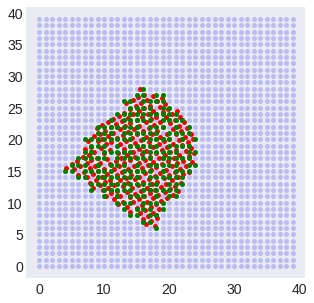

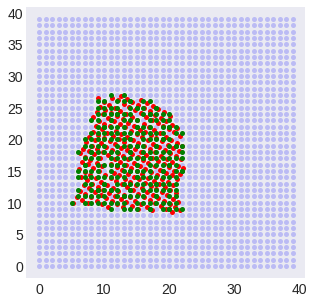

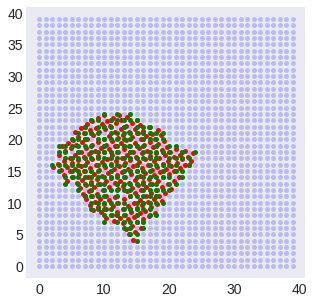

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8457475443833278

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15558417539446645

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0003118689148569054



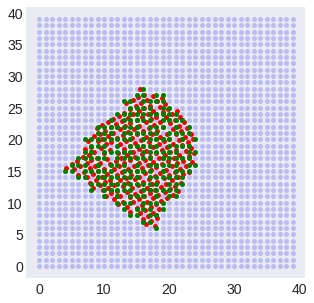

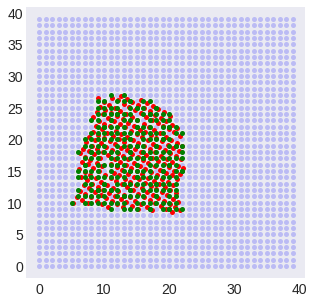

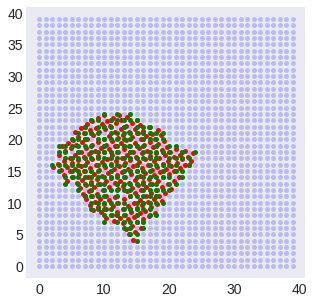

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.023942047369333

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15322376494119916

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0007359283901313685



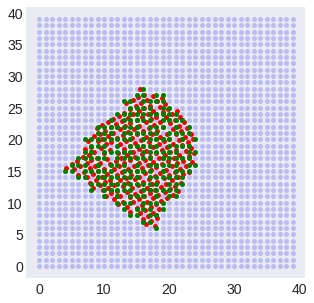

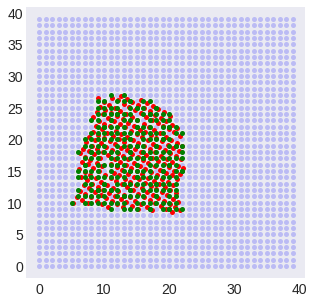

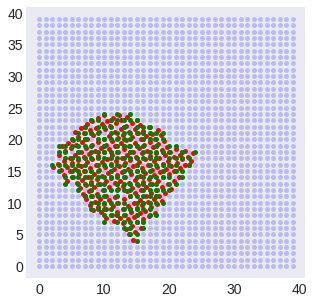

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



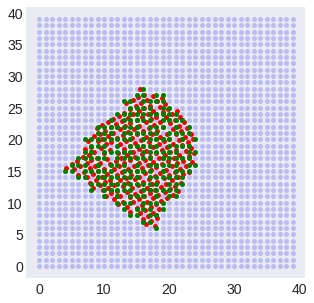

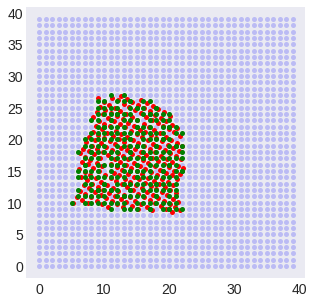

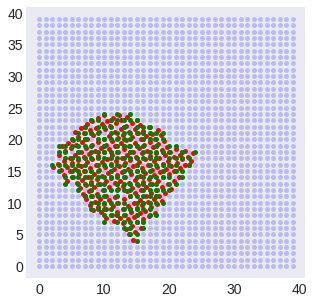

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9131589172955765

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15618737854060316

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.6982966439371694e-05



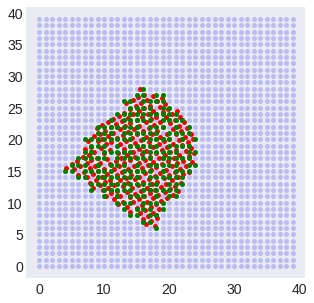

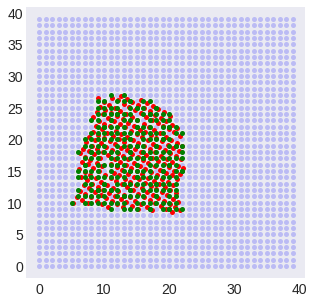

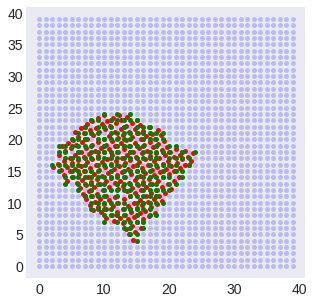

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.0285276629520825

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15670453676115503

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0002918015433550636



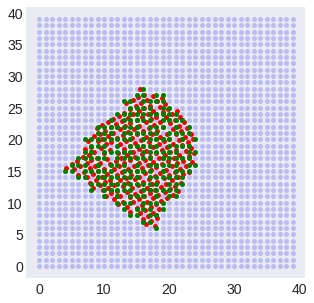

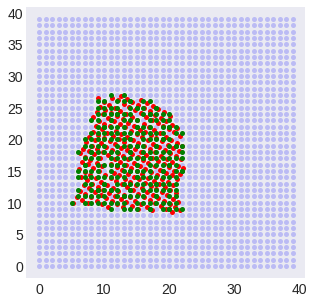

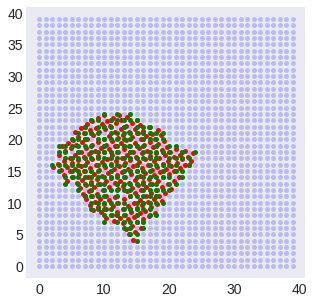

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



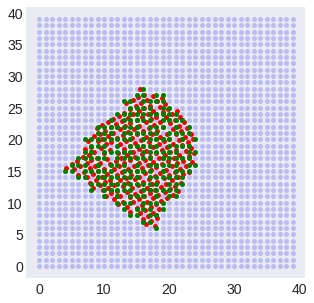

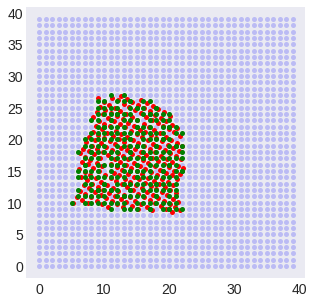

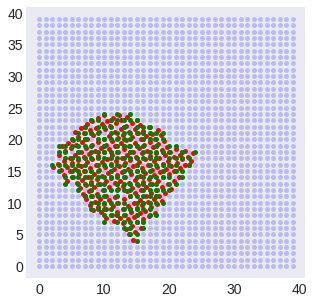

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9826629576949866

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1634609490474077

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0006443732161096616



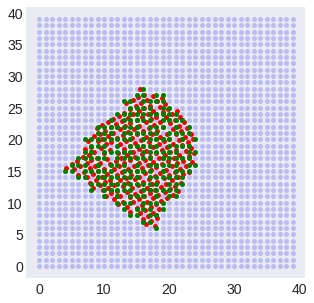

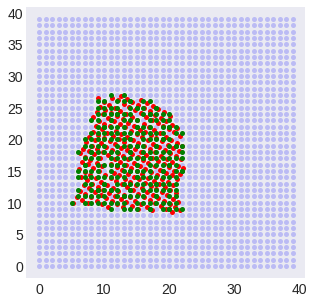

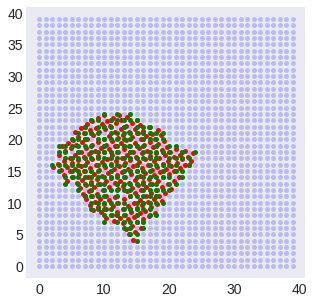

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.017950360214189

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.16262674006811473

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0019780660673089923

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00020125896811107324



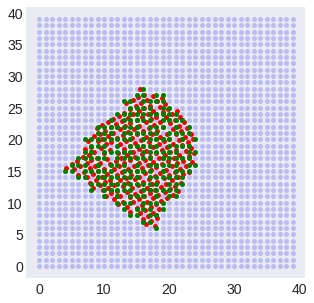

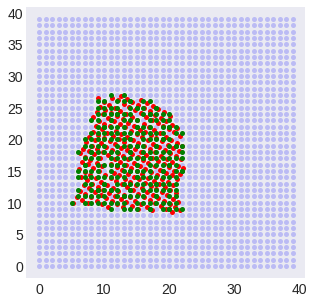

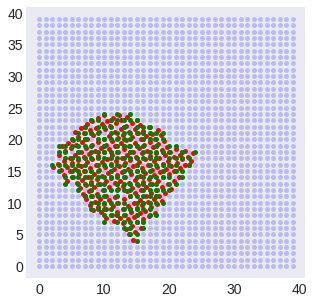

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0

IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII= 4


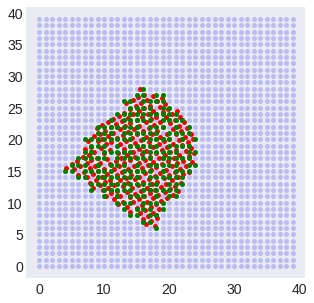

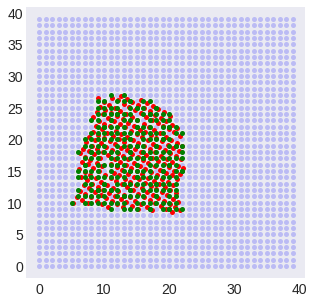

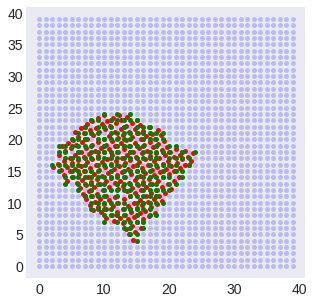

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 1.976802705074478

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0698947599998796

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping

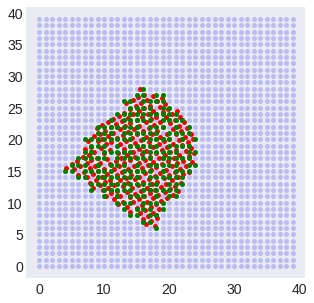

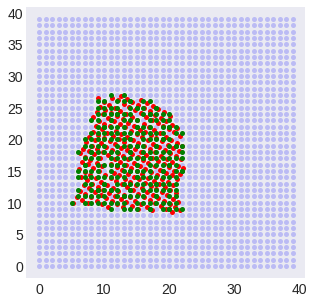

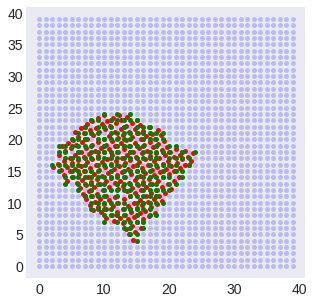

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 2.0732073079192563

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.07732983370655777

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mappi

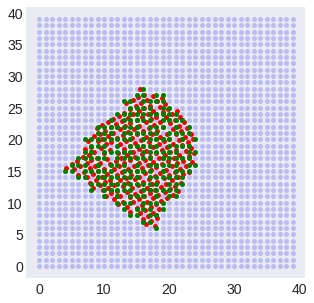

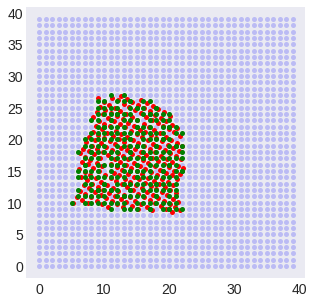

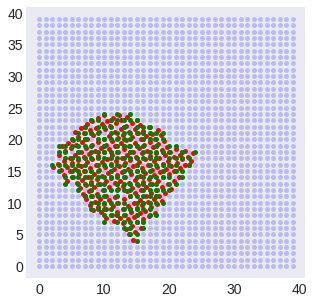

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0



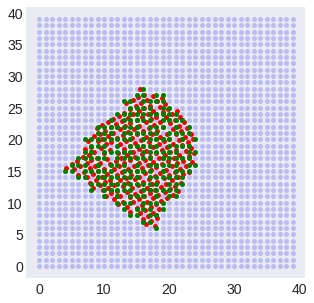

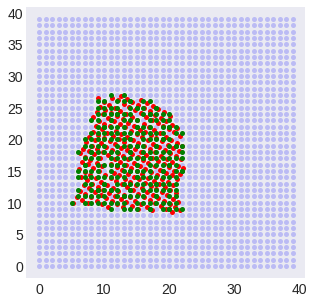

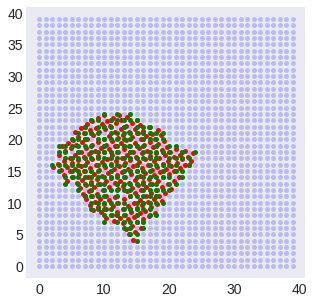

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8479391039611046

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.13532541604244397

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.002641242780068387

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0004515199530106262



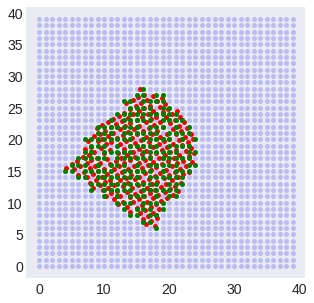

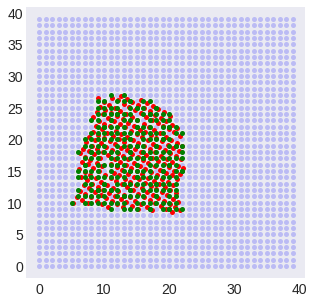

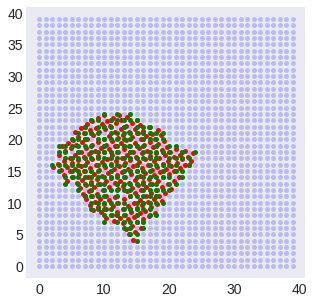

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9738058706060195

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15052664084078282

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.002868944503907178

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.001975916091994101

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.002681857475015592

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0012170392956678544

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.002571570493554942

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0003871167454312374



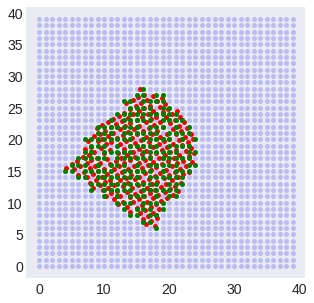

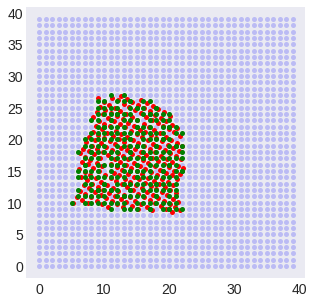

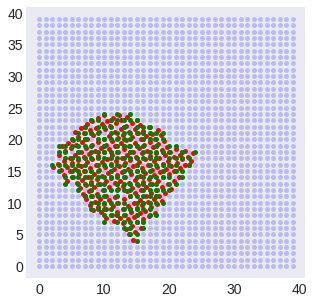

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



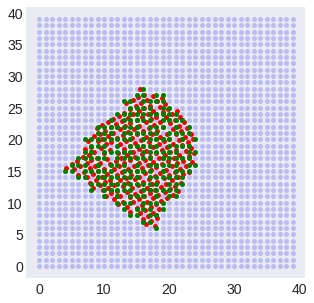

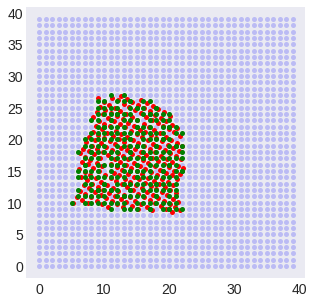

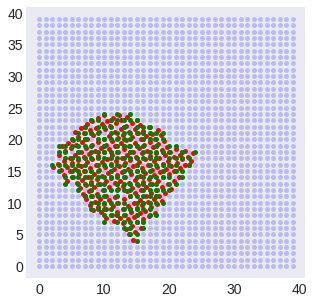

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.826998906103122

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.14374898994294028

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0009610448505941172



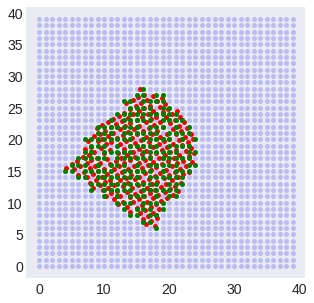

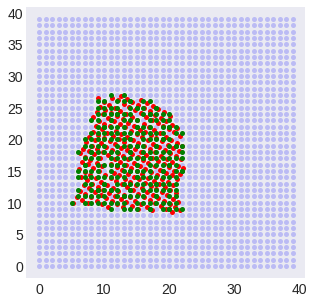

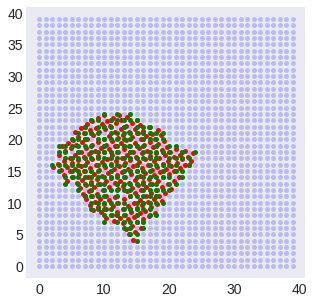

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9899611111715274

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1567924315970417

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0014823405156145775

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0024942577468052285

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0017402828319166286

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.001579257569436665

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00123827677838384

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0005859054692052279



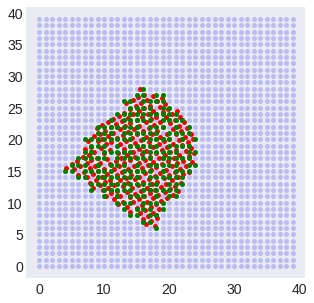

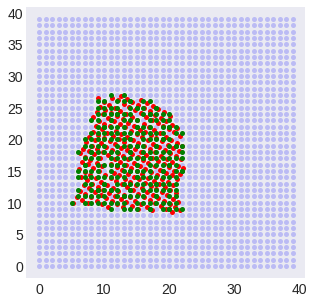

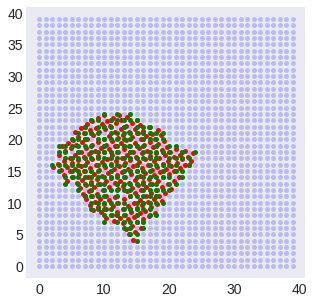

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



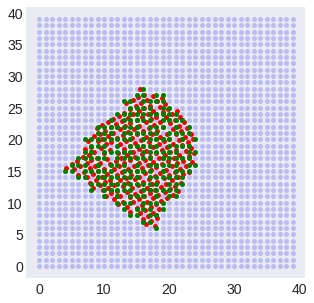

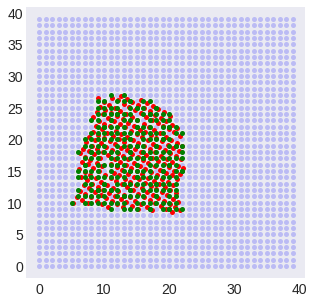

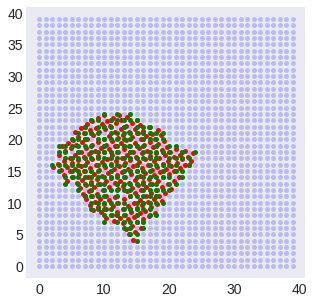

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.860000378637562

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1562060387041151

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 8.27895158361791e-05



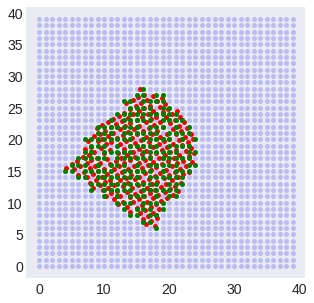

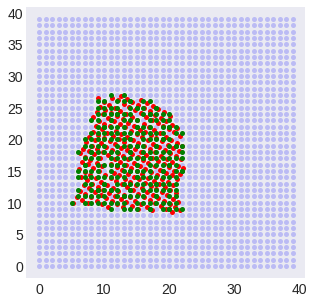

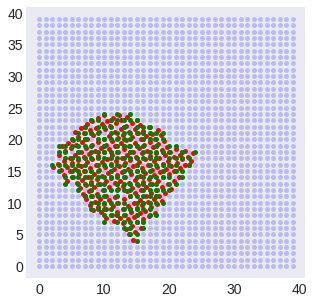

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.0205483721885034

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.16506337085585532

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00040338491672109456



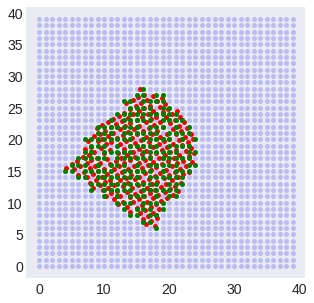

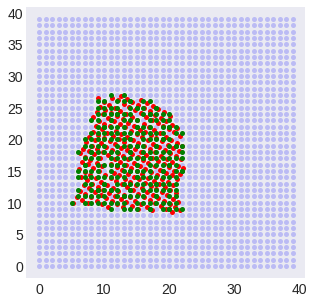

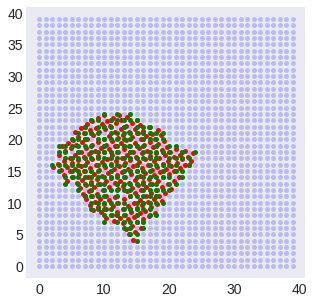

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



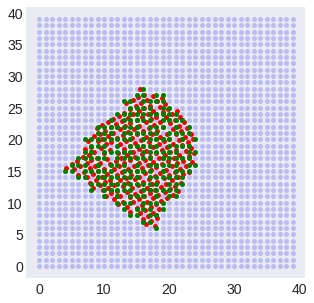

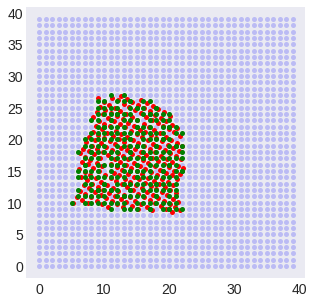

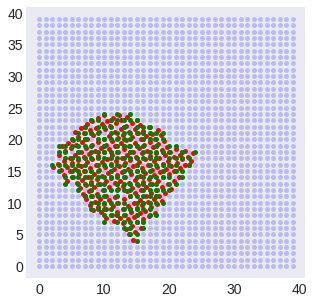

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8793839478886167

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.16243931958873548

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0002503146924242028



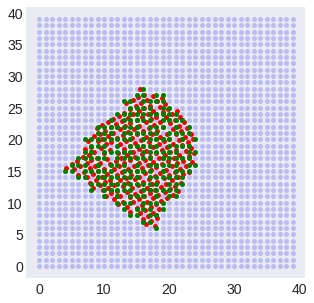

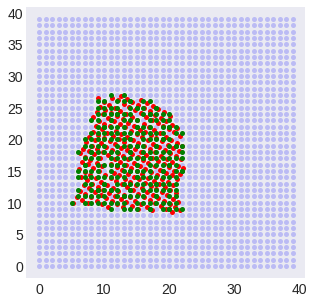

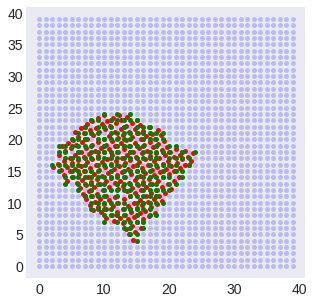

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.0061545836698382

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.17113654076120532

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0005260275678347082



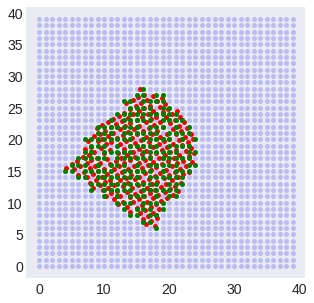

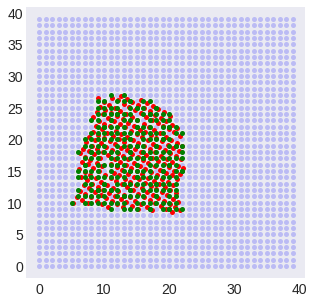

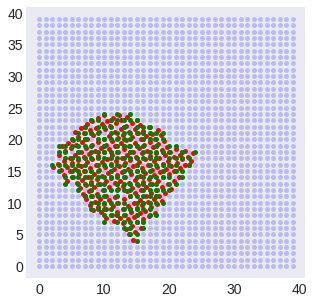

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



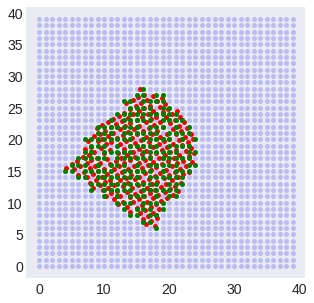

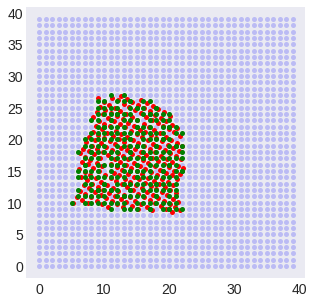

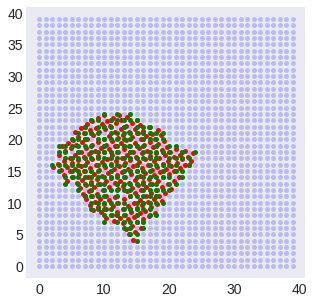

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8415328397021926

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.152451489921954

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00013786985467834079



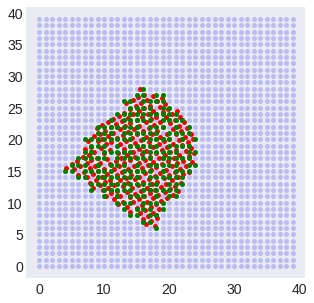

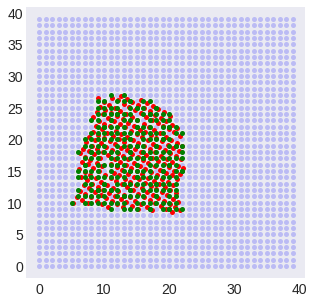

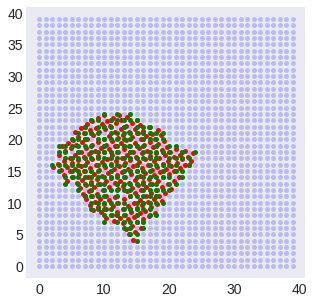

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9955052091712637

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.14846748390717912

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0015187119332882304

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0015753699669796006

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0021628206362567237

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0017826127579263495

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0011286950841997712

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00047431380187457073



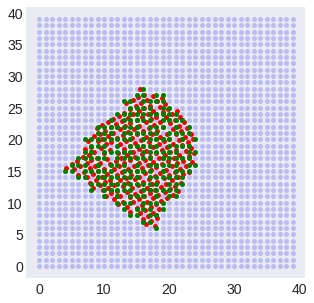

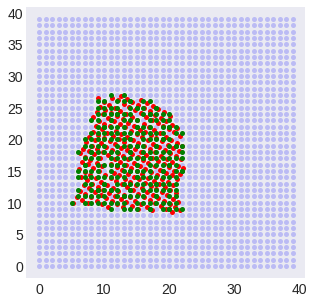

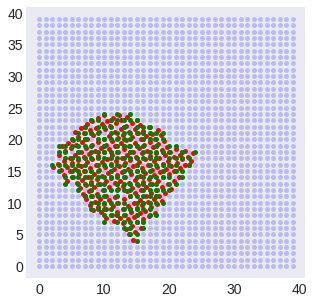

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0



/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [46]:
pseudocounts = [0, 1, 2, 3, 4, 5]
baseline_runs = []
mixed_runs = []
spatial_runs = []
for i in range(5):
    print("IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII= " + str(i))
    mixed = []
    baseline = []
    spatial = []
    mixed_acc = []
    baseline_acc = []
    spatial_acc = []
    for p in pseudocounts:
        m = sim(adata_layer_1, p, 0.1)
        b = sim(adata_layer_1, p, 0)
        s = sim(adata_layer_1, p, 1)
        mixed.append(m)
        baseline.append(b)
        spatial.append(s)
        # mixed_acc.append(m_acc)
        # baseline_acc.append(b_acc)
        # spatial_acc.append(s_acc)
    baseline_runs.append(np.mean(baseline, axis=1))
    mixed_runs.append(np.mean(mixed, axis=1))
    spatial_runs.append(np.mean(spatial, axis=1))
    

## Plot Results for simulation.

In [55]:
baseline = np.mean(baseline_runs, axis = 0)
spatial = np.mean(spatial_runs, axis = 0)
mixed = np.mean(mixed_runs, axis = 0)

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or m

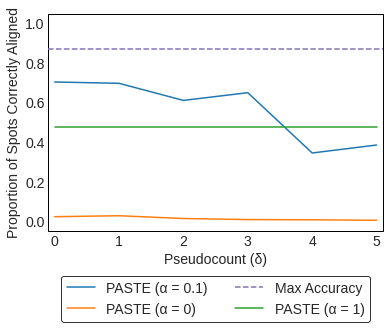

In [57]:
ax = sns.lineplot(pseudocounts, mixed, label = "PASTE (α = 0.1)")
ax = sns.lineplot(pseudocounts, baseline, label = "PASTE (α = 0)")
ax = sns.lineplot(pseudocounts, spatial, label = "PASTE (α = 1)")
ax.axhline(0.86852, linestyle='--', label = 'Max Accuracy', c = '#8172b2')
ax.set(xlim=(-0.1,5.1), ylim=(-0.05,1.05))
ax.set_facecolor('white')
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('1')  
ax.set_xlabel('Pseudocount (δ)', fontsize = 14)
ax.set_ylabel('Proportion of Spots Correctly Aligned', fontsize = 14)
h, l = ax.get_legend_handles_labels()
handles = [h[0],h[1],h[3],h[2]] 
labels = [l[0],l[1],l[3],l[2]] 
ax.legend(handles, labels, loc= 'lower center', bbox_to_anchor=(0.5, -0.45), ncol=2, frameon=True, edgecolor='black', facecolor='white', fontsize=14)
# plt.savefig('center_sim_sliceB.pdf', dpi = 300, bbox_inches = "tight")